## Learning objective
- Use Statistics of the data to get the best model of one feature.
- Intro to linear regression: Predict the best model of two features, where one feature is used to predict the average value you'd observe for the other feature 
- Use statsmodels to mget the best linear regression model
- Describe the various tests of a linear regression model

In [2]:
## some imports...
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt
import statsmodels.api as sm


geno = pd.read_table("../data/arabmagic/arabmagic_geno.csv", sep=",",skiprows=3,index_col=0)
pheno = pd.read_table("../data/arabmagic/arabmagic_pheno.csv", sep=",",skiprows=3,index_col=0)
fruit_length_geno = pd.read_table("../data/arabmagic/fruit_length_geno.csv",sep=",",index_col=0)

In [3]:
pheno['fruit_length']

id
MAGIC.1      14.95
MAGIC.2      13.27
MAGIC.3      13.90
MAGIC.4      15.93
MAGIC.5      12.81
             ...  
MAGIC.699    15.13
MAGIC.700      NaN
MAGIC.701    15.98
MAGIC.702    17.19
MAGIC.703    16.65
Name: fruit_length, Length: 677, dtype: float64

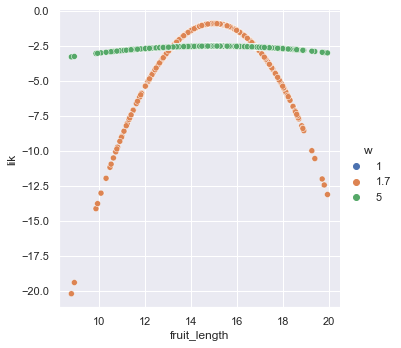

In [4]:
import matplotlib.pyplot as plt
norm_loc15 = norm(loc=15)
norm_loc15_w = norm(loc=15,scale=1.)
norm_loc15_w2 = norm(loc=15,scale=5)

df = pd.DataFrame({'fruit_length':list(pheno['fruit_length']) + list(pheno['fruit_length']) +
                                   list(pheno['fruit_length']),
                   'lik':list(np.log(norm_loc15.pdf(pheno['fruit_length']))) +
                         list(np.log(norm_loc15_w.pdf(pheno['fruit_length']))) + 
                         list(np.log(norm_loc15_w2.pdf(pheno['fruit_length']))),
                     'w':['1']*pheno.shape[0] + ['1.7']*pheno.shape[0] + ['5']*pheno.shape[0]})
sns.relplot(data=df, x = 'fruit_length', y ='lik', hue='w')
            

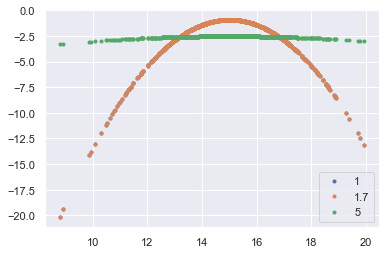

In [5]:
f,ax = plt.subplots(1)
ax.plot(pheno['fruit_length'],np.log(norm_loc15.pdf(pheno['fruit_length'])),'.')
ax.plot(pheno['fruit_length'],np.log(norm_loc15_w.pdf(pheno['fruit_length'])),'.')
ax.plot(pheno['fruit_length'],np.log(norm_loc15_w2.pdf(pheno['fruit_length'])),'.')
ax.legend([1,1.7,5])

## 1. Maximum likelihood & statistics
By mathematically deriving the maximum likelihood value of the parameters, it can be shown:

The best Bernoulli model uses the statistics of the data: fraction of 1s as `p`

In [6]:
binary_marker = (fruit_length_geno['MASC06116']=='A').astype(int)
print(binary_marker.head())
print(binary_marker.mean())

MAGIC.1    1
MAGIC.2    1
MAGIC.3    1
MAGIC.4    1
MAGIC.5    1
Name: MASC06116, dtype: int32
0.9276218611521418


The best Normal model uses the statistics of the data:
- `loc` is mean of the observations
- `scale` is standard deviation

In [7]:
pheno['fruit_length'].mean()

14.941394658753708

In [8]:
fr_std = pheno['fruit_length'].std()

## 2 Normal models for subsets of your data
Now that we have an idea about making a good model for the data, let's make a good model for subsets of the data.

**Exercise 2.1**: Find good values for `scale` and `loc` to make a good model for plant with genotype A.

In [9]:
fruit_length_geno.loc[ fruit_length_geno['MASC06116']=='A','fruit_length'].describe()

count    625.000000
mean      15.148368
std        1.643411
min        9.860000
25%       14.110000
50%       15.060000
75%       16.270000
max       19.940000
Name: fruit_length, dtype: float64

In [10]:
fruit_length_geno.loc[ fruit_length_geno['MASC06116']!='A','fruit_length'].describe()

count    49.000000
mean     12.301429
std       1.541018
min       8.790000
25%      11.220000
50%      12.340000
75%      13.270000
max      15.570000
Name: fruit_length, dtype: float64

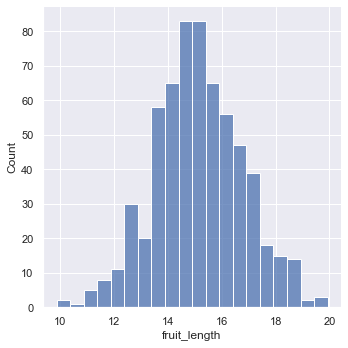

In [11]:
sns.displot( fruit_length_geno.loc[ fruit_length_geno['MASC06116']=='A','fruit_length'])

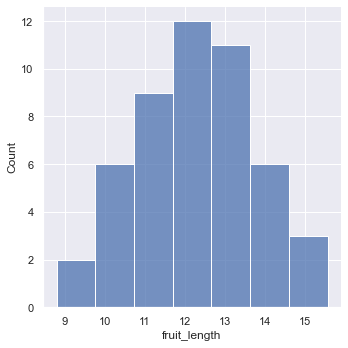

In [12]:
sns.displot( fruit_length_geno.loc[ fruit_length_geno['MASC06116']!='A','fruit_length'])

**Exercise 2.2**: Try generating observations from the model you made for genotype A (as many as there are plants with genotype B). Get the data for the real and generated plants and fill in the code below. Run the code cell to make a histogram of each with matplotlib. How does it look?

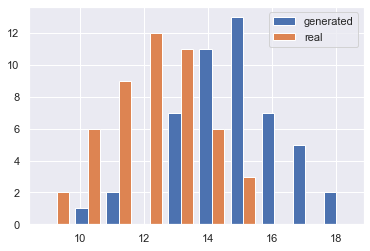

In [13]:
realB = fruit_length_geno.loc[ fruit_length_geno['MASC06116']!='A','fruit_length']
realB = realB.dropna()
modelA = norm(loc=15.1,scale= 1.64)
genA = modelA.rvs(48)

import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
ax.hist([genA, realB])
ax.legend(['generated','real'])

**Exercise 2.3**: Just eyeballing it, make another model you think would be a better fit for your dta. Then, verify that this model actually has  better likelihood score by comparing the likelihood from the model from 2.3.1 versus the model you made here.

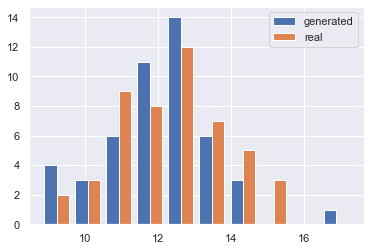

In [14]:
realB = fruit_length_geno.loc[ fruit_length_geno['MASC06116']!='A','fruit_length']## get real fruit lengths for MASC06116 = B plants
realB = realB.dropna()
modelB = norm(loc=12.30, scale = 1.54)
genB = modelB.rvs(48)## generate same number of plants

import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
ax.hist([genB, realB])
ax.legend(['generated','real'])

In [15]:
-np.log(modelB.pdf(realB)).sum()

90.21709833150925

# 3. Linear models
Imagine you're a real estate broker. You are estimating total house prices

|Bedrooms|Bathrooms|Renovated|Total|
|--- |--- |--- |--- |
|2|2|0|300,000|
|4|4|1|1,000,000|

Then one prediction could be calculated simply...

  $total = bedrooms \times priceBedroom + bathrooms \times priceBathroom + renovated \times priceRenovation$

With a linear model we state a hypothesis such as: *fruit length depends on genotype* and we basically are saying:
- we know the plants have some kind of normal distribution
- but the **predicted mean** of that distribution could be different for plants depending on the values of their other features

To put our hypothesis in terms the computer can understand:
- loc (mean) follows a formula like:

   ${mean Fruit Length} = intercept + slope \times binaryMarker $
   

Let's start by picking values for intercept and slope that we think would make a model that best fits our data.

0.9276218611521418

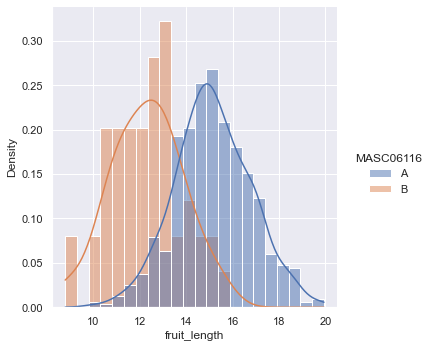

In [16]:

sns.displot(data=fruit_length_geno, x="fruit_length", hue='MASC06116',stat='density',common_norm=False, kde=True)
binary_marker.mean()

**Exercise 3.1**: Pick values for intercept and slope that you think would make a model that fits our data, just by eyeballing it. Then, use this to get the predicted mean value for plants in each category. Compare that to the actual means for plants in the 2 categories.

In [17]:
intercept=12
slope=3


Like I said, now we could have a different mean predicted for each plant-- just like each house could have a different mean. We can generate random values with different means from Normal by providing **list of values** for `loc` -- then you get 1 random value for each value of loc:

In [18]:
null_lengths = pd.isnull(pheno['fruit_length']) 
true_lengths = (null_lengths == False) 
pheno2 = pheno[true_lengths]



In [19]:
fruit_length_geno['MASC06116'] == 'A'

MAGIC.1      True
MAGIC.2      True
MAGIC.3      True
MAGIC.4      True
MAGIC.5      True
             ... 
MAGIC.699    True
MAGIC.700    True
MAGIC.701    True
MAGIC.702    True
MAGIC.703    True
Name: MASC06116, Length: 677, dtype: bool

**Exercise 3.2**: Compare generated values to the real values
1. Calculate the value of `loc` for each plant (2 unique values, but calculated for each of the plants) using vectorized math and the slope and intercept you picked. 
2. Use this value to generate `rvs` from normals with those means.
3. Put your generated plants into the fruit_length_geno data frame and make the histogram comparing the generated fruit lengths (you can copy the displot code above.

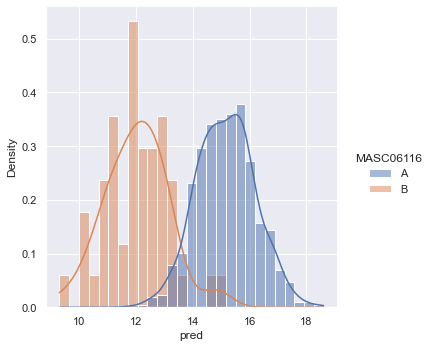

In [20]:
# Calculate the mean of each plant type
mean_A = fruit_length_geno.loc[fruit_length_geno['MASC06116'] == 'A', 'fruit_length'].mean()
mean_B = fruit_length_geno.loc[fruit_length_geno['MASC06116'] == 'B', 'fruit_length'].mean()
# Get the difference between them
diff = mean_A - mean_B
# Calculate the loc for each plant based on its genotype
loc_plants = (fruit_length_geno['MASC06116'] == 'A').astype(int) * diff + mean_B
# Generate artificial values using the calculated locs above and add it to the dataframe
pred_plants = norm.rvs(loc=loc_plants)
fruit_length_geno['pred'] = pred_plants

# Make a histogram comparing the two
sns.displot(data=fruit_length_geno, x="pred", hue='MASC06116',stat='density',common_norm=False, kde=True)


In [21]:
mean_B

12.301428571428568

In [22]:
loc_plants

MAGIC.1      15.148368
MAGIC.2      15.148368
MAGIC.3      15.148368
MAGIC.4      15.148368
MAGIC.5      15.148368
               ...    
MAGIC.699    15.148368
MAGIC.700    15.148368
MAGIC.701    15.148368
MAGIC.702    15.148368
MAGIC.703    15.148368
Name: MASC06116, Length: 677, dtype: float64

In [23]:
# fruit_length_geno['gen_fl'] = geno

ValueError: Wrong number of items passed 703, placement implies 1

**Exercise 3.3**: Set the intercept equal to the mean value for genotype B (about 12.3), and the scale value to the best maximum likelihood scale (you can review section 1). Use the maximum likelihood method to get the slope that best fits the data (try 20 different slopes between 1 and 4. Plot the value of the slope parameter against the likelihood of the data under that slope parameter.

2.894736842105263


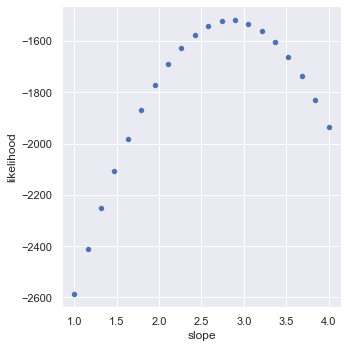

In [24]:
import numpy as np
slopes = np.linspace(1,4,20)
data = fruit_length_geno.loc[~pd.isnull(fruit_length_geno['fruit_length']), :]
binary_marker = (data['MASC06116'] == 'A').astype(int)

lik = []
for slope in slopes:
    loc_plants = binary_marker * slope + mean_B
    probs = norm(loc_plants).pdf(data['fruit_length'])
    logs = np.log(probs)
    lik.append(logs.sum())

d = {'slope':slopes, 'likelihood':lik}
print(slopes[lik.index(max(lik))])
sns.relplot(data=d, y='likelihood', x='slope')

# 4. Using `statsmodels` to find the parameters of our model
Obviously, this could get more difficult if we wanted to find the best intercept AND slope  or if we wanted to make a more complicated model to predict the mean, such as including the height of the plant in the model, or other genotype markers.

Generally we do not find the parameters manually, but through using modeling packages like `statsmodels`. Here is how we import it:

In [25]:
import statsmodels.api as sm

Then, we make a data frame containing the data we want to model:

In [27]:
fruit_length_geno.head()

,bolting_days,seed_weight,seed_area,ttl_seedspfruit,branches,height,pc_seeds_aborted,fruit_length,MN1_29291,MN1_29716,...,MN5_26121184,MN5_26220737,MN5_26379737,MN5_26380009,MN5_26437895,MN5_26438023,MN5_26708459,MN5_26877341,MN5_26877463,pred
MAGIC.1,15.33,17.15,0.64,45.11,10.50,NaN,0.00,14.95,A,A,...,A,B,A,B,A,A,A,A,A,15.380420
MAGIC.2,22.00,22.71,0.75,49.11,4.33,42.33,1.09,13.27,A,A,...,A,A,A,A,A,A,B,A,A,13.646991
MAGIC.3,23.00,21.03,0.68,57.00,4.67,50.00,0.00,13.90,A,A,...,A,B,A,B,H,A,A,A,A,14.554168
MAGIC.4,18.67,22.45,0.74,54.33,6.33,NaN,0.23,15.93,A,A,...,A,A,A,A,A,A,A,A,A,17.256892
MAGIC.5,18.67,25.36,0.82,38.33,5.67,42.25,0.00,12.81,B,B,...,A,A,A,A,A,A,A,B,B,14.070052


### 4.1 Make the data frame to model

In [28]:
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "MASC06116": binary_marker})
to_model

,fruit_length,MASC06116
MAGIC.1,14.95,1.0
MAGIC.10,18.63,1.0
MAGIC.100,16.36,1.0
MAGIC.101,17.65,1.0
MAGIC.102,16.52,1.0
...,...,...
MAGIC.95,14.95,1.0
MAGIC.96,14.29,1.0
MAGIC.97,15.56,1.0
MAGIC.98,13.78,1.0


Then, in order to model an intercept as well as a slope, we use the `add_constant` function:

In [29]:
to_model = sm.add_constant(to_model)

c:\Users\sjcde\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


This is because the model works multiplying each column by a number and adding up across the columns. So now we are saying fruit length follows a model that looks like:
${mean Fruit Length} = intercept \times 1  + slope \times genotypeNumber $

We didn't change much! Any number times 1 is the same number.

In [30]:
to_model.head()

,const,fruit_length,MASC06116
MAGIC.1,1.0,14.95,1.0
MAGIC.10,1.0,18.63,1.0
MAGIC.100,1.0,16.36,1.0
MAGIC.101,1.0,17.65,1.0
MAGIC.102,1.0,16.52,1.0


## 4.2 Convert to input for Statsmodels and run the model

Then we split the data up into the **feature** we want to model (fruit length) and the features we will use to predict that feature

**Exercise 4.2.1**: 

*A*. Remove the rows of `to_model` where there are any null values, and save this back to the variable `to_model`.

*B*. Then make 2 data frames, `y` that *just* has fruit length (this is the data we are trying to model), and `X` that has the other columns but *not* the fruit length

Then print out the `head()` of both

In [31]:
to_model= to_model.dropna()
to_model

,const,fruit_length,MASC06116
MAGIC.1,1.0,14.95,1.0
MAGIC.10,1.0,18.63,1.0
MAGIC.100,1.0,16.36,1.0
MAGIC.101,1.0,17.65,1.0
MAGIC.102,1.0,16.52,1.0
...,...,...,...
MAGIC.95,1.0,14.95,1.0
MAGIC.96,1.0,14.29,1.0
MAGIC.97,1.0,15.56,1.0
MAGIC.98,1.0,13.78,1.0


In [32]:
y = pd.DataFrame (to_model['fruit_length'])
x = to_model.drop('fruit_length',axis=1)

In [ ]:
y.head()

,fruit_length
MAGIC.1,14.95
MAGIC.2,13.27
MAGIC.3,13.90
MAGIC.4,15.93
MAGIC.5,12.81


In [ ]:
x

,const,MASC06116
MAGIC.1,1.0,1
MAGIC.2,1.0,1
MAGIC.3,1.0,1
MAGIC.4,1.0,1
MAGIC.5,1.0,1
...,...,...
MAGIC.697,1.0,1
MAGIC.699,1.0,1
MAGIC.701,1.0,1
MAGIC.702,1.0,1


Now, we can use statsmodels to **fit** the best model for fruit length based on the genotype info. Note that statsmodels also uses the maximum likelihood method, but it does it in a different way.

In [33]:
model_marker = sm.OLS(y, x).fit()

The `summary()` function of the model object prints out a nice summary with lots of info... Compare the intercept (const) and slope (MASC06116) to what we got above. Also notice the log-likelihood:

In [34]:
model_marker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fruit_length   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     137.5
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           4.98e-29
Time:                        13:13:14   Log-Likelihood:                -1287.3
No. Observations:                 674   AIC:                             2579.
Df Residuals:                     672   BIC:                             2588.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3014      0.234     52.625      0.000      11.842      12.760
MASC06116      2.8469      0.243     11.728      0.000       2.370       3.324
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.168
Skew:                           0.033   Prob(JB):                        0.919
Kurtosis:                       3.040   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.1 Understanding the model parameters
You can get the model parameters using the **attribute** `params`:
${mean Fruit Length} = intercept \times 1  + slope \times genotypeNumber $


In [36]:
model_marker.params

const        12.301429
MASC06116     2.846939
dtype: float64

**Exercise 4.1.1**: Use the data frame `X` and model parameters to predict the mean fruit length value for each plant, like we did in Exercise 3.2 (step 1) but now using `X` which has 2 columns, and using `model_marker.params`. 

In [37]:
# Calculate the mean of each plant type
total_mean = model_marker.params[0] + model_marker.params[1]*(to_model['MASC06116']==1.0)
# Calculate the loc for each plant based on its genotype
total_mean



MAGIC.1      15.148368
MAGIC.10     15.148368
MAGIC.100    15.148368
MAGIC.101    15.148368
MAGIC.102    15.148368
               ...    
MAGIC.95     15.148368
MAGIC.96     15.148368
MAGIC.97     15.148368
MAGIC.98     15.148368
MAGIC.99     15.148368
Name: MASC06116, Length: 674, dtype: float64

**Exercise 4.1.2**: The model object has a function called `predict` that will predict the mean fruit length for each observation (plant) in X. Compare the predicted means against your results from Exercise 4.1.1. 

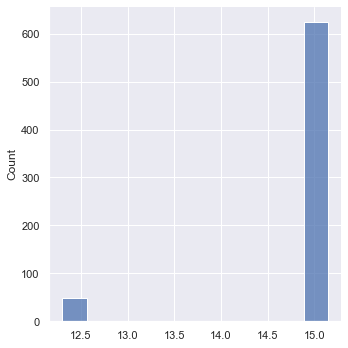

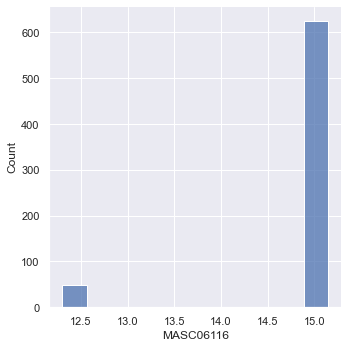

In [38]:
predicted_values = model_marker.predict(x)
total_mean
sns.displot(predicted_values)
sns.displot(total_mean)

we predicted same mean value across each B markers but the predicted values in B are in a range of values also same thing apply to  A 

**Exercise 4.1.3**: describe in everyday words the meaning of the slope parameter.

a number that represent a how much a unit change in parameter A will change the unit B

**Exercise 4.1.4**: Run the model again but using just the intercept, not using the marker. Look at the model parameters now. Describe how it relates to the univariate models we made before (models of just fruit length). Why did the model give you this value?

In [39]:
new_model = sm.OLS(y, x['const']).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fruit_length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                nan
Time:                        13:13:34   Log-Likelihood:                -1350.0
No. Observations:                 674   AIC:                             2702.
Df Residuals:                     673   BIC:                             2707.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9414      0.069    216.144      0.000      14.806      15.077
==============================================================================
Omnibus:                        4.599   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.459
Skew:                          -0.168   Prob(JB):                        0.108
Kurtosis:                       3.213   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

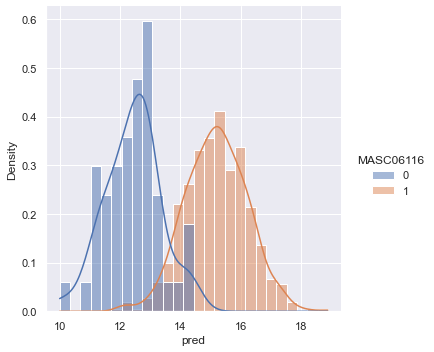

In [ ]:
loc_plants = predicted_values
pred_plants = norm.rvs(loc=loc_plants)
to_model['pred'] = pred_plants
sns.displot(data=to_model, x="pred", hue='MASC06116',stat='density',common_norm=False, kde=True)

In [ ]:
sm.OLS(pred_plants, x).fit().params

const        12.430111
MASC06116     2.762000
dtype: float64

In [41]:
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],
                         "MASC06116": (fruit_length_geno['MASC06116']=='A').astype(int)})
                                                                                    ###^^ can add *2 here
to_model = to_model.loc[ pd.isnull(to_model).sum(axis=1)==0, :]
to_model = sm.add_constant(to_model)
X = to_model.loc[:,['const','MASC06116']]
y = to_model['fruit_length']
model_marker = sm.OLS(y, X).fit()
model_marker.summary()

c:\Users\sjcde\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fruit_length   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     137.5
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           4.98e-29
Time:                        13:13:43   Log-Likelihood:                -1287.3
No. Observations:                 674   AIC:                             2579.
Df Residuals:                     672   BIC:                             2588.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3014      0.234     52.625      0.000      11.842      12.760
MASC06116      2.8469      0.243     11.728      0.000       2.370       3.324
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.168
Skew:                           0.033   Prob(JB):                        0.919
Kurtosis:                       3.040   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.2 Uncertainty about parameters

Is the true effect of that genotype exactly 2.846963? 


This is just a noisy estimate of what the true value of the parameter is

Maybe there's some true effect that that genotype has, by changing the function of some gene/protein. We are using our sample of 677 plants to estimate what that true effect is. If we got a new set of plants, hopefully it would be a similar estimate but probably not the same. What we want is:
1. A fairly reliable estimate of the **true effect** of genotype on the fruit length
2. A rough idea of how confident we could be in that single number.

**Exercise 4.2.1**: Generate random fruit lengths based on our predicted means above (like in 4.1.3), with the best-fit `scale`. Then, we are generating fruit lengths that follow a *known true value for intercept and slope*. Fit the model again using these fruit lengths. What do you get for the parameters? Do you get exactly 2.84963?

In [42]:
fr_std = pheno['fruit_length'].std()
predicted_values = model_marker.predict(X)
pred_plants = norm.rvs(loc=predicted_values, scale=fr_std)
sm.OLS(pred_plants, X).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     125.9
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           6.85e-27
Time:                        13:13:47   Log-Likelihood:                -1321.2
No. Observations:                 674   AIC:                             2646.
Df Residuals:                     672   BIC:                             2655.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2815      0.246     49.960      0.000      11.799      12.764
MASC06116      2.8639      0.255     11.218      0.000       2.363       3.365
==============================================================================
Omnibus:                        2.443   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.258
Skew:                           0.124   Prob(JB):                        0.323
Kurtosis:                       3.138   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### No, we will get somrthing around that every time a different number

So the `std err` or *standard error* describes the spread we'd expect between different estimates if we could redo the data collection.

Let's see what kind of spread we actually get:

**Exercise 4.2.2**: Examine the spread in the estimate of the effect of the genotype by doing the following steps:
- Generate your 674 plants from this known model 100 times (just like in 4.2.1), and for each time, fit the model, get the slope. 
- make a histogram of the slopes
- get the mean and standard error of these

In [43]:
pred_plants.std()

1.8722194996599024

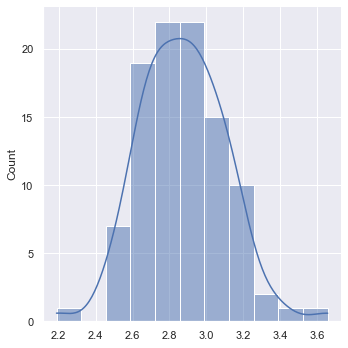

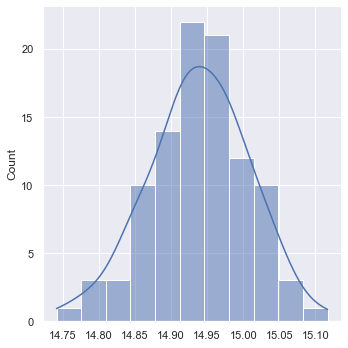

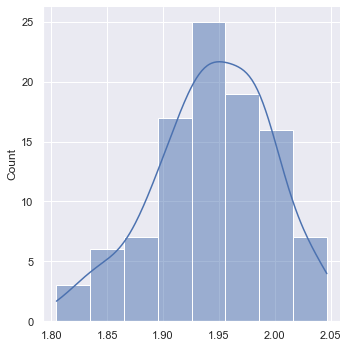

In [44]:
slops = []
means = []
stds = []
for _ in range(100):
    pred_plants = norm.rvs(loc=predicted_values, scale=fr_std)
    slops.append(sm.OLS(pred_plants, X).fit().params[1])
    means.append(pred_plants.mean())
    stds.append(pred_plants.std())
sns.displot(slops, kde=True)
plt.show()
sns.displot(means, kde=True)
plt.show()
sns.displot(stds, kde=True)
plt.show()

The p-value follows directly from the standard error. We want to know whether the slope we're getting is different from zero, which would be no effect of the genotype on the fruite length. 

The p-value says: how frequently would we see a parameter value this big, if the true parameter value is zero?

**Exercise 4.2.3**: Imagine instead of 0.243 the standard error was 2.43.  What would the histogram above look like? Can we say the true value is definitely higher than zero?
- The data range would be much wider, ranging from about -2 to 6
- We can no longer say the true value is definitely higher than 0

**Exercise 4.2.4**: Adapt your code from 4.2.1 to generate plants with slope = 0 and fit the model, and make a histogram. How often do you see a slope as big as 2.7? (the value from the real data)

In [45]:
fr_std = pheno['fruit_length'].std()
predicted_values = model_marker.predict(X)
pred_plants = norm.rvs(loc=predicted_values, scale=fr_std)
y = 0 * pred_plants + 12.094897
sm.OLS(y, X).fit().params



const        1.209490e+01
MASC06116    2.375877e-14
dtype: float64

### 4.3 Linear regression with a *number* feature as a predictor
But we don't have to use only binary features as predictors. 

Let's make a new model:

   ${mean Fruit Length} = intercept + slope \times height $
   

**Exercise 4.3.1**: Make a scatter plot of fruit length versus height.  What do you think the intercept and slope would be? You can also use `sns.regplot` (regression plot) instead of `sns.relplot` to add a line to the plot

<AxesSubplot:xlabel='height', ylabel='fruit_length'>

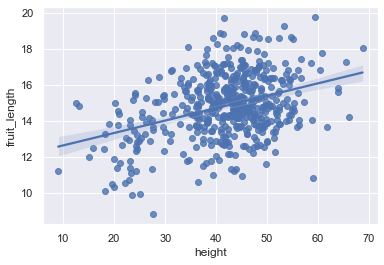

In [53]:
sns.regplot(data=fruit_length_geno , y='fruit_length' , x = 'height')

**Exercise 4.3.2**: Run the regression.
1. Create the input data frames and run the regression. Call your new model `model_height`. You may need to get rid of `NA` (missing) values.

2. What are the meanings of the parameters of the model? Explain it in everyday terms. Write it down:

3. Plot the predicted values of fruit length as a function of height on top of the true values in a scatter plot, with height on the x axis. Do this by creding predictied values and put it in your to_model data frame. You could to use the real/generated column I showed you how to make before, but this is a bit easier in matplotlib.

In [63]:
import matplotlib.pyplot as plt
to_model = pd.DataFrame({"fruit_length":fruit_length_geno['fruit_length'],"height":fruit_length_geno['height']})
to_model = sm.add_constant(to_model)
to_model = to_model.dropna()
X = to_model.loc[:, ['const', 'height']]
y = to_model['fruit_length']
model_height = sm.OLS(y, X).fit()

c:\Users\sjcde\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
# Constant: A plant with 0 height will have a fruit length of 12
# Slope: For every unit increase in height, fruit length increases by 0.069
model_height.params

const     11.941920
height     0.069106
dtype: float64

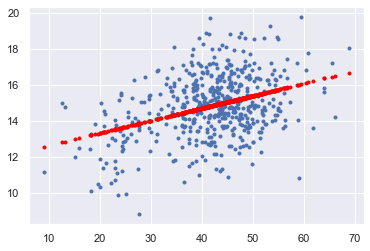

In [61]:
to_model['pred'] = model_height.predict(X)
f, ax = plt.subplots(1)
ax.plot( to_model['height'], to_model['fruit_length'],'.')
ax.plot( to_model['height'], to_model['pred'],'.', color='red')

The **correlation coefficient** is a number between -1 and +1 that summarizes the relationship between two variables. Values near 0 indicate no relationship. Values nearer 1 indicate a positive relationship (like fruit length and height) and values less than 0 have an inverse relationship. We can calculate the correlation of all columns in a data frame using `corr`:

In [57]:
pheno.corr()

,bolting_days,seed_weight,seed_area,ttl_seedspfruit,branches,height,pc_seeds_aborted,fruit_length
bolting_days,1.000000,0.020657,0.190081,-0.314102,0.199622,-0.300998,0.115896,-0.094510
seed_weight,0.020657,1.000000,0.861198,-0.250136,-0.064932,0.271370,-0.084994,0.043456
seed_area,0.190081,0.861198,1.000000,-0.486536,0.008840,0.140160,0.035747,-0.056702
ttl_seedspfruit,-0.314102,-0.250136,-0.486536,1.000000,-0.145372,0.152190,-0.224499,0.501261
branches,0.199622,-0.064932,0.008840,-0.145372,1.000000,-0.144360,0.047236,-0.088763
height,-0.300998,0.271370,0.140160,0.152190,-0.144360,1.000000,-0.155076,0.363397
pc_seeds_aborted,0.115896,-0.084994,0.035747,-0.224499,0.047236,-0.155076,1.000000,-0.108998
fruit_length,-0.094510,0.043456,-0.056702,0.501261,-0.088763,0.363397,-0.108998,1.000000


**Exercise 4.3.3**: Creating a new model
1. Plot one pair of phenotypes that has a negative correlation less than -0.2. 

<AxesSubplot:xlabel='seed_area', ylabel='ttl_seedspfruit'>

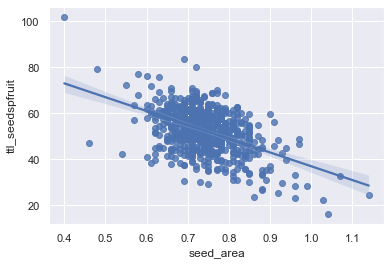

In [64]:
sns.regplot(data=pheno, x='seed_area', y='ttl_seedspfruit')

2. What kind of linear model do you propose? **Predict** the intercept and slope.

In [ ]:
# I would propose a negative linear model
# Based on the two points (0.57, 62) and (1.07, 38) I would predict:
# slope= -48, intercept= 80

3. Create and then run the model. Compare your predicted intercept and slope against what the model gives you.

In [65]:
to_model = pd.DataFrame({"seed_area":pheno['seed_area'],"ttl_seedspfruit":pheno['ttl_seedspfruit']})
to_model = sm.add_constant(to_model)
to_model = to_model.dropna()
X = to_model.loc[:, ['const', 'seed_area']]
y = to_model['ttl_seedspfruit']
sm.OLS(y, X).fit().params

# Both were much further away from 0 than I predicted!

c:\Users\sjcde\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const        97.040219
seed_area   -60.073360
dtype: float64

## 5. Linear regression Model metrics
A **metric** is a formula we calculate using the data + the model to figure out how well the model fits the data

**Question**: what metrics have we discussed so far? 

In [58]:
model_marker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fruit_length   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     137.5
Date:                Thu, 17 Nov 2022   Prob (F-statistic):           4.98e-29
Time:                        13:29:31   Log-Likelihood:                -1287.3
No. Observations:                 674   AIC:                             2579.
Df Residuals:                     672   BIC:                             2588.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3014      0.234     52.625      0.000      11.842      12.760
MASC06116      2.8469      0.243     11.728      0.000       2.370       3.324
==============================================================================
Omnibus:                        0.247   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.168
Skew:                           0.033   Prob(JB):                        0.919
Kurtosis:                       3.040   Cond. No.                         7.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5.1 Residuals

The difference between our predicted average value of fruit length and the actual value is called the **residual**. You can think of this as the **error** in our prediction... the bigger the difference, the worse we did.

**Exercise 5.1.1**: Get the predictions for `model_marker` and save it in a variable called `predicted values`. Calculate the residuals  of fruit length.  

You can also get this using the attribute `resid`:

In [59]:
model_marker.resid

MAGIC.1     -0.198368
MAGIC.2     -1.878368
MAGIC.3     -1.248368
MAGIC.4      0.781632
MAGIC.5     -2.338368
               ...   
MAGIC.697   -0.678368
MAGIC.699   -0.018368
MAGIC.701    0.831632
MAGIC.702    2.041632
MAGIC.703    1.501632
Length: 674, dtype: float64

**Exercise 5.1.2**: Make a strip plot or violin plot of residuals for plants separated by the 2 values of genotypeNumber (refer to Seaborn docs [here](https://seaborn.pydata.org/generated/seaborn.catplot.html))

The **root mean squared error or RMSE** is a measure of how well your predictions fit the data. It is defined as:
1. square the residuals (*squared error*)
2. get the mean of the squared residuals (*mean squared error*)
3. take the square root of that (*root mean squared error*)

**Exercise 5.1.3**: Calculate Root Mean Squared Error using your predictions.

You can calculate root mean squared error using the `rmse` function, alongside your predicted values as follows:

In [60]:
from statsmodels.tools.eval_measures import rmse
rmse(predicted_values, y)

ValueError: operands could not be broadcast together with shapes (674,) (511,) 

### 5.2 R-squared

R-squared tells us the percent of variation in the fruit_length that is explained by the model, which we can see is 17% of the variation:

In [ ]:
model_marker.rsquared

In [ ]:
pheno['fruit_length'].var()

**Exercise 5.2.1**: Predict the mean values based on only genotype and intercept and get the variance of these (using `var()`). Divide that by the variance of the fruit_lengths overall to calculate fraction of variance explained. Compare that to the `rsquared`.

**Exercise 5.2.2**: Is height a better predictor of fruit length? How can we use the summaries of the regression model to answer that question? Compare the models in 3 different metrics.

## 6 Regressions with more than 1 predictor
Linear regression uses the maximum likelihood method to build a model of the **dependent variable (aka response)** feature where instead of the mean being a constant number (like 12) the mean of the model depends on the **independent variable (aka predictor)** features (fruit length mean = 12 + 3 * genotypeNumber). The value we expect for the dependent variable *depends* on the value of the independent variables.

We've been just using the first marker in fruit_length_geno to predict fruit_length. Let's try a different marker.

In [ ]:
fruit_length_geno.head()

**Exercise 6.1**: Using a different marker to predict fruit length (Model 2) 
1. Use the marker MASC02863 as a predictor variable and do regression predicting fruit length (save this into a variable called `model2`.

2. Write down the linear model including the coefficients of the model. 

3. Calculate the predicted mean fruit lengths and the RMSE

4. Is this marker a good predictor of fruit length? Why?

But there's no reason we have to pick one. We can use more than one by including it in the data frame `X`.

**Exercise 6.2**: Using both markers (Model 3).
1. Run the regression now including both MASC06116 and MASC02863 as predictors of fruit length  (save this into a variable called `model3`). How can we compare it to the other models?

2. Write out the linear model that includes both markers, including the actual numbers of the parameters (rounded to 2 decimals).

3. There are 4 possible genotypes considering these 2 markers, which is all combinations of A and B at the 2 markers. The values are below in the data frame `genoPairs`. Use the linear model in step 2 (or, if you prefer, the `predict` function) to predict mean fruit lengths for plants in the 4 categories. Add this prediction as a column to the data frame. 

4. Compare the slope parameters for model_marker, model2, and model 3. What do you notice? Add another column to the genoPairs data frame that uses the slope parameters from Model 1 and Model 2, together to make predictions. What do you notice?

### 6.1 Collinearity of two independent variables
When two independent variables have almost the same values, they can't both have a high slope if they are together in the same model. Even if when they have a high slope when they are in separate models.

We can use the `crosstab` function to see what combinations of genotypes are present across the plants.

In [ ]:
pd.crosstab(fruit_length_geno['MASC06116'],
            fruit_length_geno['MASC02863'])

**Exercise 6.1.1**: In your own words describe the relationship between the two markers by looking at this table. 

**Exercise 6.1.2**: Make another model `model4` that has 2 predictors, but now both predictors are the genotype at marker MASC06116 (so we have 2 identical independent variables). Compare the coefficients and r-squared between Model 4 and Model 1. What do you notice?